In [61]:
import numpy as np
import pandas as pd
import scipy.optimize as opt
from scipy.interpolate import interp1d
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from uncertainties import ufloat
from uncertainties import unumpy
import scipy.misc as misc


In [78]:
def photo_function(x, stopping, slope):
    return np.piecewise(x, [x>stopping, x<=stopping], [lambda x: slope * (x - stopping), 0])

def model(x, m, b):
    return m * x + b

def push_xerr(x, xerr, y, yerr, fitted_model):
    pushed_xerr = xerr * misc.derivative(fitted_model, x)
    add_quad = np.sqrt(yerr ** 2 + pushed_xerr ** 2)
    return add_quad

def get_x_int(m, b):
    return -b / m


In [63]:
mV_v = np.array([0.0, -200, -400, -600, -800, -900, -1000, -1100, -1200, -1250, -1275, -1300, 100, 200, 300, 400, 500])
nA_v = np.array([3424, 2434, 1573, 851, 345, 185, 92, 30, 10, 4, 0, 0, 3929, 4426, 4937, 5447, 5963])
mV_v = np.sort(mV_v)
nA_v = np.sort(nA_v)

mV_r = np.array([0.0, -100, -200, -300, -400, -500, -550, -575, -600, -625, -650, -700, 100, 200, 300, 400, 500])
nA_r = np.array([800, 560, 343, 174, 65, 23, 12, 9, 3, 1, 0, 0, 1042, 1279, 1526, 1759, 1994])
mV_r = np.sort(mV_r)
nA_r = np.sort(nA_r)

mV_g = np.array([500, 400, 300, 200, 100, 0.0, -50, -100, -125, -150, -175, -200])
nA_g = np.array([642, 542, 434, 309, 187, 81, 41, 16, 7, 3, 0, 0])
mV_g = np.sort(mV_g)
nA_g = np.sort(nA_g)


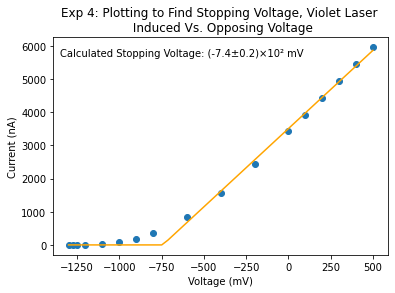

In [64]:
# Does the fit
init_params=[0,0]
lin_opt, lin_cov = opt.curve_fit(photo_function, mV_v, nA_v, p0=init_params)

# Best fit values
stopping_v, slope_v = lin_opt
dStopping_v, dSlope_v = np.sqrt(np.diag(lin_cov))

plt.title("Exp 4: Plotting to Find Stopping Voltage, Violet Laser \n Induced Vs. Opposing Voltage")
plt.ylabel("Current (nA)")
plt.xlabel("Voltage (mV)")
x_space = np.linspace(mV_v[0],mV_v[-1])
plt.scatter(mV_v, nA_v)
plt.plot(x_space, photo_function(x_space, stopping_v, slope_v), color='orange')
text = "Calculated Stopping Voltage: " u'{:.1eP}'.format(ufloat(stopping_v, dStopping_v))

plt.text(-1350, 5700, text+" mV")
plt.show()

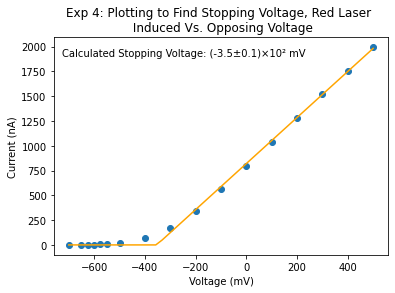

In [65]:
# Does the fit
init_params=[0,0]
lin_opt, lin_cov = opt.curve_fit(photo_function, mV_r, nA_r, p0=init_params)

# Best fit values
stopping_r, slope_r = lin_opt
dStopping_r, dSlope_r = np.sqrt(np.diag(lin_cov))

plt.title("Exp 4: Plotting to Find Stopping Voltage, Red Laser \n Induced Vs. Opposing Voltage")
plt.ylabel("Current (nA)")
plt.xlabel("Voltage (mV)")
x_space = np.linspace(mV_r[0],mV_r[-1])
plt.scatter(mV_r, nA_r)
plt.plot(x_space, photo_function(x_space, stopping_r, slope_r), color='orange')
text = "Calculated Stopping Voltage: " u'{:.1eP}'.format(ufloat(stopping_r, dStopping_r))

plt.text(-725, 1900, text+" mV")
plt.show()

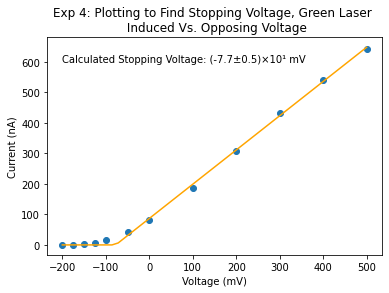

In [66]:
# Does the fit
init_params=[0,0]
lin_opt, lin_cov = opt.curve_fit(photo_function, mV_g, nA_g, p0=init_params)

# Best fit values
stopping_g, slope_g = lin_opt
dStopping_g, dSlope_g = np.sqrt(np.diag(lin_cov))

plt.title("Exp 4: Plotting to Find Stopping Voltage, Green Laser \n Induced Vs. Opposing Voltage")
plt.ylabel("Current (nA)")
plt.xlabel("Voltage (mV)")
x_space = np.linspace(mV_g[0],mV_g[-1])
plt.scatter(mV_g, nA_g)
plt.plot(x_space, photo_function(x_space, stopping_g, slope_g), color='orange')
text = "Calculated Stopping Voltage: " u'{:.1eP}'.format(ufloat(stopping_g, dStopping_g))

plt.text(-200, 600, text+" mV")
plt.show()


In [82]:
stopping = -1 * np.array([stopping_v, stopping_g, stopping_r]) * 10**-3
stopping_err = np.array([dStopping_v, dStopping_g, dStopping_r]) * 10**-3
energy = 1.602176634e-19 * stopping * 6.242e+18
energy_err = 1.602176634e-19 * stopping_err * 6.242e+18
wavelength_unc = np.array([ufloat(405, .5), ufloat(634.6, .05), ufloat(532, .5)]) * 10**-9
freq_unc = 299792458 / wavelength_unc
freq = unumpy.nominal_values(freq_unc)
freq_err = unumpy.std_devs(freq_unc)



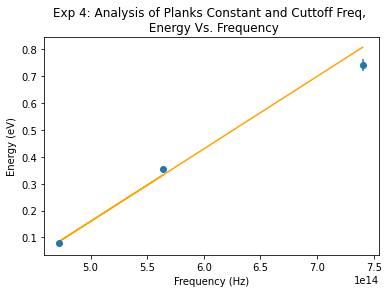

In [87]:
# Does naive the fit
init_params=[0, 0]
lin_opt, lin_cov = opt.curve_fit(model, freq, energy)
m, b = lin_opt

def fitted_lin(x):
    return model(x, m, b)

new_energy_err = push_xerr(freq, freq_err, energy, energy_err, fitted_lin)
                                 
lin_opt, lin_cov = opt.curve_fit(model, freq, energy, sigma=new_energy_err, absolute_sigma=True, p0=init_params)
plt.title("Exp 4: Analysis of Planks Constant and Cuttoff Freq, \n Energy Vs. Frequency")

# Best fit values
m, b = lin_opt
dm, db = np.sqrt(np.diag(lin_cov))
m_unc = ufloat(m, dm)
b_unc = ufloat(b, db)

plt.errorbar(freq, energy, xerr=freq_err, yerr=energy_err, fmt='o')
plt.plot(freq, model(freq, m, b), color='orange')
plt.ylabel("Energy (eV)")
plt.xlabel("Frequency (Hz)")

plt.show()

In [70]:
stopping

array([0.74291188, 0.35326064, 0.07717668])

In [ ]:
freq

array([7.40228291e+14, 4.72411689e+14, 5.63519658e+14])

In [90]:
print(u'{:.1eP}'.format(get_x_int(m_unc, b_unc)))

(4.4±0.2)×10¹⁴


In [91]:
print(u'{:.1eP}'.format(m_unc))

(2.7±0.1)×10⁻¹⁵


In [92]:
def agreement(accepted, experimental):
    discrep = np.abs(accepted.n - experimental.n)
    acc_discrep = 2 * np.sqrt(accepted.s ** 2 + experimental.s ** 2)
    if discrep < acc_discrep:
        sign = "<"
    elif discrep > acc_discrep:
        sign = ">"
    else:
        sign = "="

    return print("|V_{acc} - V_{exp}| = ",  discrep, sign, acc_discrep, " = 2\sqrt{\\alpha_{acc}^2+\\alpha_{exp}^2}")

In [93]:
agreement(get_x_int(m_unc, b_unc), ufloat(4.136e-15, .0005e-15))

|V_{acc} - V_{exp}| =  440923558078065.94 > 34368788001963.42  = 2\sqrt{\alpha_{acc}^2+\alpha_{exp}^2}


In [94]:
agreement(m_unc, ufloat(4.62e14, .005e14))

|V_{acc} - V_{exp}| =  462000000000000.0 > 1000000000000.0  = 2\sqrt{\alpha_{acc}^2+\alpha_{exp}^2}
